### Description of the Code

This script implements a multimodal deep learning pipeline that fuses text and image data for classification tasks. The code is structured as follows:
1. **Suppressing Warnings and Setting Up Environment Variables**
   - The script configures TensorFlow and PyTorch to minimize verbose warnings, ensuring a cleaner runtime log.
   - CUDA-related environment variables are set to optimize GPU usage and prevent redundant library loading.

2. **Library Imports**
   - Essential libraries for deep learning (`torch`, `tensorflow`), dataset handling (`torchvision`, `transformers`), and utilities (`numpy`, `psutil`) are imported.

3. **Testing Pretrained Model Loading**
   - The script ensures that `MobileNetV2` (for images) and `DistilBERT` (for text) are successfully moved to the selected device (CPU/GPU).

4. **Dataset Loading and Processing**
   - Image files are loaded from specified directories, and text labels are extracted from filenames.
   - Labels are adjusted to start from 0, if necessary.
   - Class weights are computed to handle class imbalance, which is useful for improving model performance on underrepresented classes.
   - Image transformations (resizing, normalization) and text tokenization (using `DistilBERTTokenizer`) are applied.

5. **Custom Dataset Class**
   - Implements a PyTorch `Dataset` class to handle text, images, and labels together.
   - The `__getitem__` function ensures that both modalities are processed and returned in a suitable format for training.

6. **DataLoader Creation**
   - Training and validation datasets are loaded into PyTorch `DataLoader` objects with proper batching and sampling strategies.

7. **Attention-Based Fusion Model**
   - **Image Branch**: Uses `MobileNetV2` with its feature extractor frozen to prevent unnecessary weight updates.
   - **Text Branch**: Uses `DistilBERT`, allowing fine-tuning.
   - **Attention Mechanism**: A learned attention layer assigns importance weights to text and image features before fusion.
   - **Final Classification**: A simple fully connected network with dropout and ReLU activation classifies the fused features.

8. **Training Process**
   - The model is trained using cross-entropy loss and the AdamW optimizer.
   - A learning rate scheduler reduces learning rate upon plateauing validation loss.
   - **Regularization:**
     - **Dropout layers** (`dropout_prob=0.3`) are included to mitigate overfitting.
     - **Weight decay (`weight_decay=1e-3`)** in `AdamW` helps prevent exploding weights.
   - **Early stopping** prevents unnecessary computation when validation loss stops improving.

9. **Testing and Evaluation**
   - The best model (saved during training) is loaded and evaluated on the test set.
   - Test accuracy is computed to assess model performance.

---

### Regularization Considerations

1. **Dropout Layers (`dropout_prob=0.3`)**
   - Applied in the fully connected layers of both text and image branches.
   - Helps reduce overfitting by randomly deactivating neurons during training.

2. **Weight Decay (`weight_decay=1e-3`)**
   - Applied in the AdamW optimizer to prevent excessive weight updates.
   - Controls model complexity by penalizing large weights.

3. **Freezing Pretrained Weights**
   - In the image model (`MobileNetV2`), feature extraction layers are frozen to avoid overfitting small datasets.
   - Only the classifier layer is trained, reducing computational cost and improving generalization.

4. **Class Weighting in Loss Function**
   - The use of `WeightedRandomSampler` compensates for imbalanced datasets, preventing the model from being biased toward dominant classes.

5. **Early Stopping**
   - Stops training when validation loss does not improve for a set number of epochs.
   - Reduces unnecessary computation and minimizes overfitting risk.

This structured approach ensures robustness in handling multimodal data while integrating necessary regularization techniques to enhance generalization.


In [ ]:


import re
import time
import numpy as np
import torch.nn as nn
import torch.optim as optim
import psutil
from collections import Counter
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import models, transforms
from PIL import Image
from transformers import DistilBertModel, DistilBertTokenizer

# Debug snippet: Test moving each pretrained model separately
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Testing on device: {device}")

try:
    from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
    temp_img = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1).to(device)
    print("MobileNetV2 moved successfully")
except Exception as e:
    print("Error moving MobileNetV2:", e)

try:
    temp_text = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
    print("DistilBertModel moved successfully")
except Exception as e:
    print("Error moving DistilBertModel:", e)

# ----------------------------
# Data paths
# ----------------------------
TRAIN_PATH = "garbage_data/CVPR_2024_dataset_Train"
VAL_PATH   = "garbage_data/CVPR_2024_dataset_Val"
TEST_PATH  = "garbage_data/CVPR_2024_dataset_Test"

# ----------------------------
# Utility: Check RAM usage
# ----------------------------
def check_ram_usage(step):
    ram = psutil.virtual_memory()
    print(f"[{step}] RAM Usage: {ram.percent}% ({ram.used / 1e9:.2f} GB / {ram.total / 1e9:.2f} GB)")

# ----------------------------
# Data Loading Function
# ----------------------------
def load_dataset(directory):
    """
    Loads dataset from a folder structure where each subfolder corresponds to a class.
    Text is extracted from the image file name (by removing extension and replacing underscores).
    """
    image_paths, labels, texts = [], [], []
    # Create a mapping from folder name to label (0-based)
    class_folders = sorted(os.listdir(directory))
    label_map = {folder: idx for idx, folder in enumerate(class_folders)}
    print(f"Loading dataset from {directory}...")
    
    for label_folder in class_folders:
        folder_path = os.path.join(directory, label_folder)
        if os.path.isdir(folder_path):
            for file in sorted(os.listdir(folder_path)):
                file_path = os.path.join(folder_path, file)
                if os.path.isfile(file_path):
                    # Extract text from file name
                    file_name, _ = os.path.splitext(file)
                    text = file_name.replace('_', ' ')
                    text = re.sub(r'\d+', '', text)  # Optionally remove digits
                    texts.append(text)
                    labels.append(label_map[label_folder])
                    image_paths.append(file_path)
    print(f"✅ Dataset from {directory} loaded!")
    return np.array(texts), np.array(labels), np.array(image_paths)

# ----------------------------
# Load datasets
# ----------------------------
print("🚀 Starting dataset loading...")
texts_train, labels_train, image_paths_train = load_dataset(TRAIN_PATH)
texts_val, labels_val, image_paths_val       = load_dataset(VAL_PATH)
texts_test, labels_test, image_paths_test      = load_dataset(TEST_PATH)
print("✅ All datasets loaded successfully!")

# ----------------------------
# (Optional) Adjust labels if necessary
# ----------------------------
if np.min(labels_train) >= 1:
    labels_train = labels_train - 1
    labels_val   = labels_val - 1
    labels_test  = labels_test - 1

print("Unique labels in train set:", sorted(set(labels_train)))
print("Unique labels in val set:", sorted(set(labels_val)))
print("Unique labels in test set:", sorted(set(labels_test)))

# ----------------------------
# Compute class weights (for imbalanced datasets)
# ----------------------------
label_counts = Counter(labels_train)
total_samples = sum(label_counts.values())
class_weights = {label: total_samples / count for label, count in label_counts.items()}
weights = [class_weights[label] for label in labels_train]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# ----------------------------
# Initialize Tokenizer and Image Transforms
# ----------------------------
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ----------------------------
# Custom Dataset
# ----------------------------
import os
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len, image_paths):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.image_paths = image_paths
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        image_path = self.image_paths[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        
        # Load and transform image
        image = Image.open(image_path).convert("RGB")
        image = image_transforms(image)
        
        # Add the file name (only the base name)
        file_name = os.path.basename(image_path)
        
        return {
            'image': image,
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': label,
            'file_name': file_name
        }


# ----------------------------
# Create DataLoaders
# ----------------------------
max_len = 24
batch_size = 32

train_dataset = CustomDataset(texts_train, labels_train, tokenizer, max_len, image_paths_train)
val_dataset   = CustomDataset(texts_val, labels_val, tokenizer, max_len, image_paths_val)
test_dataset  = CustomDataset(texts_test, labels_test, tokenizer, max_len, image_paths_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=18, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=18, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=18, pin_memory=True)
print("✅ DataLoaders created successfully!")

# ----------------------------
# Define Attention-Based Fusion Model
# ----------------------------
class AttentionFusionModel(nn.Module):
    def __init__(self, num_classes=4, fusion_dim=256, dropout_prob=0.3):
        super(AttentionFusionModel, self).__init__()
        
        # ----- Image Branch: MobileNetV2 -----
        from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
        self.image_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        for param in self.image_model.features.parameters():
            param.requires_grad = False
        self.image_model.classifier = nn.Identity()
        self.image_fc = nn.Sequential(
            nn.Linear(1280, fusion_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        
        # ----- Text Branch: DistilBERT -----
        self.text_model = DistilBertModel.from_pretrained("distilbert-base-uncased")
        for param in self.text_model.parameters():
            param.requires_grad = False
        self.text_fc = nn.Sequential(
            nn.Linear(768, fusion_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        
        # ----- Attention Fusion -----
        self.attn_image = nn.Linear(fusion_dim, 1)
        self.attn_text  = nn.Linear(fusion_dim, 1)
        
        # ----- Final Classification -----
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(fusion_dim, num_classes)
        )
    
    def forward(self, image, input_ids, attention_mask):
        # Image branch
        img_features = self.image_model(image)              # [B, 1280]
        img_features = self.image_fc(img_features)            # [B, fusion_dim]
        
        # Text branch: use [CLS] token from DistilBERT output
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # [B, 768]
        text_features = self.text_fc(text_features)             # [B, fusion_dim]
        
        # Compute attention scores for each modality
        attn_img = self.attn_image(img_features)    # [B, 1]
        attn_txt = self.attn_text(text_features)      # [B, 1]
        attn_scores = torch.cat([attn_img, attn_txt], dim=1)  # [B, 2]
        attn_weights = torch.softmax(attn_scores, dim=1)      # [B, 2]
        
        # Fuse modalities using learned attention weights
        fused_features = attn_weights[:, 0].unsqueeze(1) * img_features + \
                         attn_weights[:, 1].unsqueeze(1) * text_features
        
        # Final classification
        logits = self.classifier(fused_features)
        return logits

# ----------------------------
# Initialize Model, Loss, Optimizer, and Device
# ----------------------------
print(f"🔧 Using device: {device}")
try:
    model = AttentionFusionModel(num_classes=4).to(device)
except Exception as e:
    print("Error during model.to(device):", e)
    raise

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# ----------------------------
# Training and Validation Loop
# ----------------------------
num_epochs = 25
early_stop_patience = 5
best_val_loss = float('inf')
early_stop_counter = 0
train_losses, val_losses = [], []

print("🚀 Starting training...")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    start_time = time.time()
    print(f"🔥 Epoch {epoch+1}/{num_epochs} started")
    
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f"🟢 Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")
    
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")
    
    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += torch.sum(preds == labels).item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = correct / len(val_dataset)
    epoch_time = time.time() - start_time
    print(f"🔵 Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, Epoch Time: {epoch_time:.2f} sec")
    scheduler.step(avg_val_loss)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model_mbnt.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("⏹️ Early stopping triggered!")
            break
torch.save(model.state_dict(), "best_model_mbnt.pth")

print("🎯 Training completed!")

# ----------------------------
# Testing
# ----------------------------
model.load_state_dict(torch.load("best_model_mbnt.pth"))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(images, input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


Testing on device: cuda
MobileNetV2 moved successfully
DistilBertModel moved successfully
🚀 Starting dataset loading...
Loading dataset from garbage_data/CVPR_2024_dataset_Train...
✅ Dataset from garbage_data/CVPR_2024_dataset_Train loaded!
Loading dataset from garbage_data/CVPR_2024_dataset_Val...
✅ Dataset from garbage_data/CVPR_2024_dataset_Val loaded!
Loading dataset from garbage_data/CVPR_2024_dataset_Test...
✅ Dataset from garbage_data/CVPR_2024_dataset_Test loaded!
✅ All datasets loaded successfully!
Unique labels in train set: [0, 1, 2, 3]
Unique labels in val set: [0, 1, 2, 3]
Unique labels in test set: [0, 1, 2, 3]
✅ DataLoaders created successfully!
🔧 Using device: cuda
🚀 Starting training...
🔥 Epoch 1/25 started
🟢 Epoch 1, Batch 0, Loss: 1.3816
🟢 Epoch 1, Batch 10, Loss: 1.3829
🟢 Epoch 1, Batch 20, Loss: 1.3702
🟢 Epoch 1, Batch 30, Loss: 1.3612
🟢 Epoch 1, Batch 40, Loss: 1.3171
🟢 Epoch 1, Batch 50, Loss: 1.3089
🟢 Epoch 1, Batch 60, Loss: 1.2197
🟢 Epoch 1, Batch 70, Loss: 1.

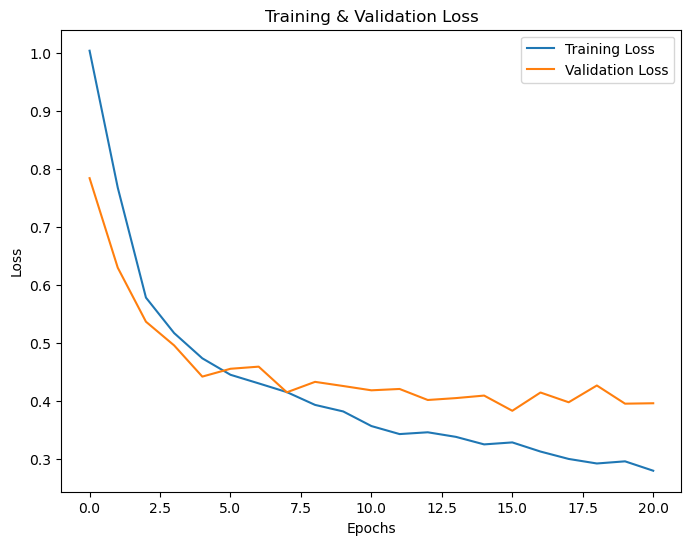

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score, confusion_matrix

# Plot training and validation losses
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()


Overall Accuracy: 0.8150
Cohen's Kappa: 0.7513
Class 0: Producer Accuracy (Recall) = 0.7353, User Accuracy (Precision) = 0.6535
Class 1: Producer Accuracy (Recall) = 0.8260, User Accuracy (Precision) = 0.8267
Class 2: Producer Accuracy (Recall) = 0.8924, User Accuracy (Precision) = 0.9248
Class 3: Producer Accuracy (Recall) = 0.7934, User Accuracy (Precision) = 0.8514


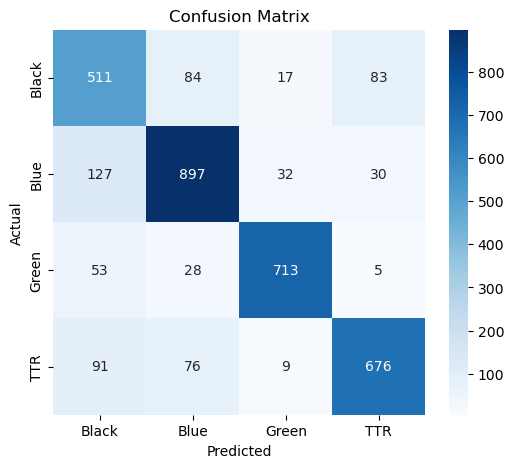


--- Correct Prediction Example ---


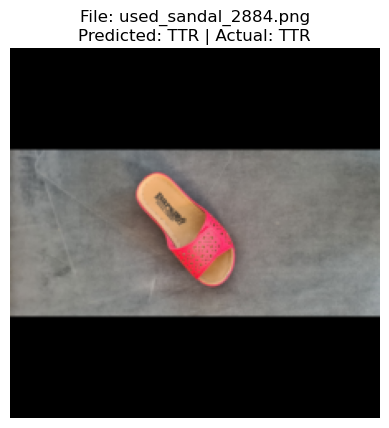

✅ The prediction is correct.

--- Incorrect Prediction Example ---


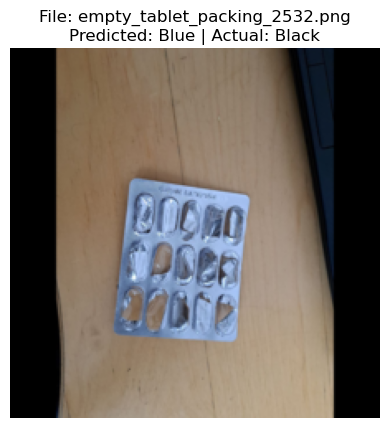

❌ The prediction is incorrect.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Define class names based on your dataset order
class_names = ["Black", "Blue", "Green", "TTR"]

def show_test_sample(dataset, idx, predictions, class_names):
    """
    Displays the test sample at dataset[idx] at input resolution along with its file name,
    predicted and actual labels.
    """
    sample = dataset[idx]
    # Unnormalize image for display
    img_tensor = sample['image']
    # Assume image is normalized with mean=[0.485,0.456,0.406] and std=[0.229,0.224,0.225]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img_np = np.clip(img_np * std + mean, 0, 1)
    
    actual_label = sample['label'].item()
    predicted_label = predictions[idx]
    # Use .get() with fallback
    file_name = sample.get('file_name', 'unknown')
    
    plt.figure()
    plt.imshow(img_np)
    plt.title(f"File: {file_name}\nPredicted: {class_names[predicted_label]} | Actual: {class_names[actual_label]}")
    plt.axis('off')
    plt.show()
    
    if predicted_label == actual_label:
        print("✅ The prediction is correct.")
    else:
        print("❌ The prediction is incorrect.")

# --- Collect predictions from the test set ---
all_true = []
all_preds = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(images, input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        
        all_true.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_true = np.concatenate(all_true)
all_preds = np.concatenate(all_preds)

# --- Compute confusion matrix and metrics ---
cm = confusion_matrix(all_true, all_preds)
overall_accuracy = np.trace(cm) / np.sum(cm)
kappa = cohen_kappa_score(all_true, all_preds)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

producer_accuracy = cm.diagonal() / cm.sum(axis=1)
user_accuracy = cm.diagonal() / cm.sum(axis=0)
for i in range(len(producer_accuracy)):
    print(f"Class {i}: Producer Accuracy (Recall) = {producer_accuracy[i]:.4f}, User Accuracy (Precision) = {user_accuracy[i]:.4f}")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# --- Identify correct and incorrect predictions ---
correct_indices = [i for i, (t, p) in enumerate(zip(all_true, all_preds)) if t == p]
incorrect_indices = [i for i, (t, p) in enumerate(zip(all_true, all_preds)) if t != p]

if len(correct_indices) > 0:
    idx_correct = np.random.choice(correct_indices)
    print("\n--- Correct Prediction Example ---")
    show_test_sample(test_dataset, idx_correct, all_preds, class_names)
else:
    print("\nNo correct predictions found!")

if len(incorrect_indices) > 0:
    idx_incorrect = np.random.choice(incorrect_indices)
    print("\n--- Incorrect Prediction Example ---")
    show_test_sample(test_dataset, idx_incorrect, all_preds, class_names)
else:
    print("\nNo incorrect predictions found!")
